In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import yfinance as yf
import math
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import torch
import torch.nn as nn

In [2]:
# Check if CUDA is available, and set the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use CUDA device
else:
    device = torch.device('cpu')  # Use CPU device

# Print the selected device
print(device)

cuda


## 2. Load data

In [3]:
# Download the 'IBM' stock data from Yahoo Finance
df_ibm = yf.download('IBM', start='2010-01-02', end='2023-04-22')

# Display the first few rows of the 'IBM' DataFrame
df_ibm.head()

# Read the sentiment scores data from a CSV file into a DataFrame
df_sent = pd.read_csv("sentiment_scores_ibm.csv")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  125.411087  127.122368  125.095604  126.625237   79.247467   
2010-01-05  125.889099  126.051628  124.378586  125.095604   78.290161   
2010-01-06  124.933075  125.707458  124.101341  124.282982   77.781586   
2010-01-07  124.158699  124.521988  123.240921  123.852776   77.512306   
2010-01-08  123.393883  125.162521  123.374763  125.095604   78.290161   
...                ...         ...         ...         ...         ...   
2023-04-17  128.300003  128.720001  126.800003  127.820000  126.100540   
2023-04-18  128.139999  128.679993  127.349998  127.779999  126.061081   
2023-04-19  126.500000  126.980003  125.300003  126.320000  124.620720   
2023-04-20  130.149994  130.979996  125.839996  

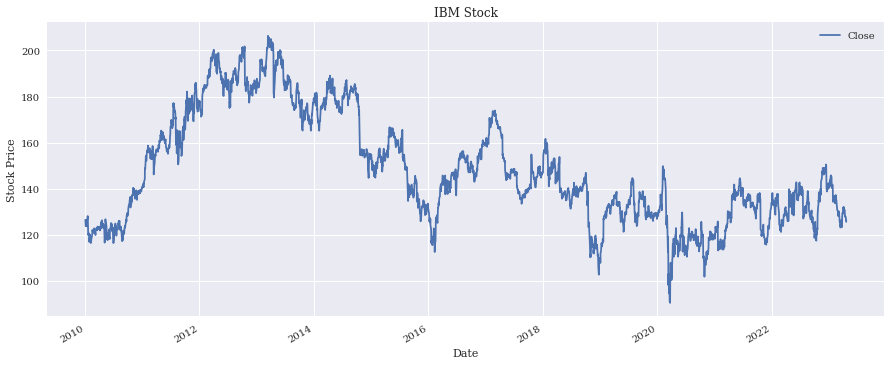

                 Close  Sentiment        VIX
Date                                        
2010-01-04  126.625237   0.000000  20.040001
2010-01-05  125.095604   0.000000  19.350000
2010-01-06  124.282982   0.000000  19.160000
2010-01-07  123.852776   0.000000  19.059999
2010-01-08  125.095604   0.000000  18.129999
...                ...        ...        ...
2023-04-17  127.820000   0.141370  16.950001
2023-04-18  127.779999   0.078264  16.830000
2023-04-19  126.320000   0.106243  16.459999
2023-04-20  126.360001   0.039800  17.170000
2023-04-21  125.730003   0.069520  16.770000

[3348 rows x 3 columns]


In [4]:
# Download the 'VIX' data from Yahoo Finance
vix = yf.download("^VIX", start='2010-01-02', end='2023-04-22')

# Remove unnecessary columns from the 'VIX' DataFrame
vix.pop('Open')
vix.pop('High')
vix.pop('Low')
vix.pop('Adj Close')
vix.pop('Volume')

# Rename the 'Close' column to 'VIX' in the 'VIX' DataFrame
vix.rename(columns={"Close": "VIX"}, inplace=True)

# Download the 'IBM' data from Yahoo Finance
df_ibm = yf.download('IBM', start='2010-01-02', end='2023-04-22')
print(df_ibm)
# Create a copy of the 'Close' column in a separate DataFrame
df_ibm_original = df_ibm[['Close']]

# Remove unnecessary columns from the 'IBM' DataFrame
df_ibm.pop('Open')
df_ibm.pop('High')
df_ibm.pop('Low')
df_ibm.pop('Adj Close')
df_ibm.pop('Volume')

# Extract the date from the index of the 'IBM' DataFrame
df_ibm['Date'] = df_ibm.index.date

# Convert the extracted date to a string for comparison
df_ibm['Date'] = df_ibm['Date'].astype(str)

# Check if the dates in the second DataFrame are present in the modified first DataFrame
mask = df_sent.iloc[:, 0].isin(df_ibm['Date'])

# Filter the second DataFrame based on the mask
filtered_df2 = df_sent[mask]

# Reset the index of the second DataFrame
filtered_df2.reset_index(drop=True, inplace=True)

# Add a new column "Sentiment" to the 'IBM' DataFrame with values from the second DataFrame's second column
df_ibm["Sentiment"] = filtered_df2.iloc[:, 1].values[:len(df_ibm)]

# Drop the sixth column from the 'IBM' DataFrame
df_ibm = df_ibm.drop(df_ibm.columns[1], axis=1)

# Plot the 'Close' column of the 'IBM' DataFrame
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("Stock Price")
plt.title("IBM Stock")
plt.show()

# Add the 'VIX' data to the 'IBM' DataFrame
df_ibm = pd.concat([df_ibm, vix], axis=1, join="inner")

# Display the modified 'IBM' DataFrame
print(df_ibm)

In [5]:
# Select the 'Close' column from the DataFrame and assign it back to df_ibm
#df_ibm = df_ibm[['Close']]

# Display information about the DataFrame
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3348 entries, 2010-01-04 to 2023-04-21
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      3348 non-null   float64
 1   Sentiment  3348 non-null   float64
 2   VIX        3348 non-null   float64
dtypes: float64(3)
memory usage: 233.7 KB


In [6]:
print(df_ibm)

# Fill missing values in the DataFrame with forward fill
df_ibm=df_ibm.fillna(method='ffill')

# Apply MinMaxScaler to normalize the data within the range of (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
#df_ibm['Open'] = scaler.fit_transform(df_ibm['Open'].values.reshape(-1,1))
#df_ibm['High'] = scaler.fit_transform(df_ibm['High'].values.reshape(-1,1))
#df_ibm['Low'] = scaler.fit_transform(df_ibm['Low'].values.reshape(-1,1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm['Adj Close'] = scaler.fit_transform(df_ibm['Adj Close'].values.reshape(-1,1))
#df_ibm['Volume'] = scaler.fit_transform(df_ibm['Volume'].values.reshape(-1,1))
df_ibm['Sentiment'] = scaler.fit_transform(df_ibm['Sentiment'].values.reshape(-1,1))
df_ibm['VIX'] = scaler.fit_transform(df_ibm['VIX'].values.reshape(-1,1))
#df_ibm

                 Close  Sentiment        VIX
Date                                        
2010-01-04  126.625237   0.000000  20.040001
2010-01-05  125.095604   0.000000  19.350000
2010-01-06  124.282982   0.000000  19.160000
2010-01-07  123.852776   0.000000  19.059999
2010-01-08  125.095604   0.000000  18.129999
...                ...        ...        ...
2023-04-17  127.820000   0.141370  16.950001
2023-04-18  127.779999   0.078264  16.830000
2023-04-19  126.320000   0.106243  16.459999
2023-04-20  126.360001   0.039800  17.170000
2023-04-21  125.730003   0.069520  16.770000

[3348 rows x 3 columns]


In [7]:
# Function to create train and test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # Convert stock data to a numpy array
    data = []

    # Create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))  # Calculate the size of the test set
    train_set_size = data.shape[0] - (test_set_size) # Calculate the size of the train set

    # Split the data into train and test sets
    x_train = data[:train_set_size,:-1,:3] # Input features for the train set
    y_train = data[:train_set_size,-1,:3] # Output targets for the train set
    
    x_test = data[train_set_size:,:-1,:3] # Input features for the test set
    y_test = data[train_set_size:,-1,:3] # Output targets for the test set
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # Choose the sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape) # Print the shape of the input features for the train set
print('y_train.shape = ',y_train.shape) # Print the shape of the output targets for the train set
print('x_test.shape = ',x_test.shape) # Print the shape of the input features for the test set
print('y_test.shape = ',y_test.shape) # Print the shape of the output targets for the test set

x_train.shape =  (2630, 59, 3)
y_train.shape =  (2630, 3)
x_test.shape =  (658, 59, 3)
y_test.shape =  (658, 3)


In [8]:
# Convert numpy arrays to torch tensors and specify the data type as Tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [9]:
y_train.size(),x_train.size()

(torch.Size([2630, 3]), torch.Size([2630, 59, 3]))

## 3. Build the structure of model

In [10]:
#####################
#### Build model ####
#####################

# Set the dimensions for input, hidden, and output layers
input_dim = 3
hidden_dim = 256  # Increased hidden dimension
num_layers = 4  # Increased number of layers
output_dim = 3

# Define the LSTM model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Dense layer 1
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu1 = nn.ReLU()

        # Dense layer 2
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.relu1(self.dense1(out[:, -1, :]))
        out = self.dropout(out)

        out = self.relu2(self.dense2(out))
        out = self.fc(out)
        return out

# Create an instance of the improved model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer and learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# Print the model architecture and the sizes of its parameters
print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

LSTM(
  (lstm): LSTM(3, 256, num_layers=4, batch_first=True)
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Number of parameters: 1978627


In [11]:
#####################
#### Train model ####
#####################

# Number of the epochs for the training
num_epochs = 2000  # 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

start_time = time.time()  # Start time for training

for t in range(num_epochs):
    epoch_start_time = time.time()  # Start time for current epoch

    # Forward pass
    y_train_pred = model(x_train)

    # Calculate the loss
    loss = loss_fn(y_train_pred, y_train)

    # Print the loss every 10 epochs
    # if t % 10 == 0 and t !=0:
    #     print("Epoch ", t, "MSE: ", loss.item())

    # Store the loss value in the history array
    hist[t] = loss.item()

    # Zero out the gradients
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    if t % 10 == 0 and t != 0:
        epoch_end_time = time.time()  # End time for current epoch
        epoch_time = epoch_end_time - epoch_start_time  # Time taken for current epoch
        print("Epoch", t, "MSE:", loss.item(), "Time: {:.3f} seconds".format(epoch_time))


end_time = time.time()  # End time for training
total_time = end_time - start_time  # Total time taken for training
print("Total training time: {:.3f} seconds".format(total_time))

Epoch 10 MSE: 0.14882691204547882 Time: 0.471 seconds
Epoch 20 MSE: 0.10173998773097992 Time: 0.449 seconds
Epoch 30 MSE: 0.09022026509046555 Time: 0.437 seconds
Epoch 40 MSE: 0.08805042505264282 Time: 0.449 seconds
Epoch 50 MSE: 0.08576779067516327 Time: 0.455 seconds
Epoch 60 MSE: 0.07688585668802261 Time: 0.487 seconds
Epoch 70 MSE: 0.04631689563393593 Time: 0.478 seconds
Epoch 80 MSE: 0.03242216259241104 Time: 0.488 seconds
Epoch 90 MSE: 0.02951190620660782 Time: 0.457 seconds
Epoch 100 MSE: 0.02831133082509041 Time: 0.444 seconds
Epoch 110 MSE: 0.027205821126699448 Time: 0.466 seconds
Epoch 120 MSE: 0.02669542469084263 Time: 0.454 seconds
Epoch 130 MSE: 0.026812396943569183 Time: 0.452 seconds
Epoch 140 MSE: 0.026088308542966843 Time: 0.456 seconds
Epoch 150 MSE: 0.025300566107034683 Time: 0.464 seconds
Epoch 160 MSE: 0.02316824346780777 Time: 0.446 seconds
Epoch 170 MSE: 0.02179441601037979 Time: 0.460 seconds
Epoch 180 MSE: 0.021283885464072227 Time: 0.455 seconds
Epoch 190 MSE:

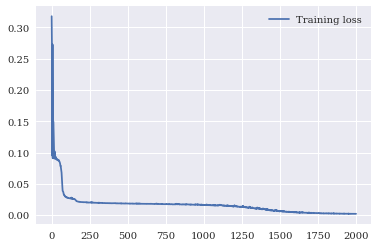

In [12]:
# Plot the training loss
plt.plot(hist, label="Training loss")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

In [13]:
# Obtain the shape of y_train_pred
np.shape(y_train_pred)

torch.Size([2630, 3])

In [14]:
# Make predictions using the trained model
y_test_pred = model(x_test)

# Invert the predictions by transforming them back to the original scale
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

# Calculate the root mean squared error (RMSE) to evaluate the model's performance
trainScore = np.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)
testScore = np.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % testScore)

# Calculate the R2 score to assess the model's goodness of fit
trainR2 = r2_score(y_train[:, 0], y_train_pred[:, 0])
print('Train R2 score: %.2f' % trainR2)
testR2 = r2_score(y_test[:, 0], y_test_pred[:, 0])
print('Test R2 score: %.2f' % testR2)

Train Score: 1.12 RMSE
Test Score: 2.36 RMSE
Train R2 score: 0.99
Test R2 score: 0.84


## 4. Predicting historical values

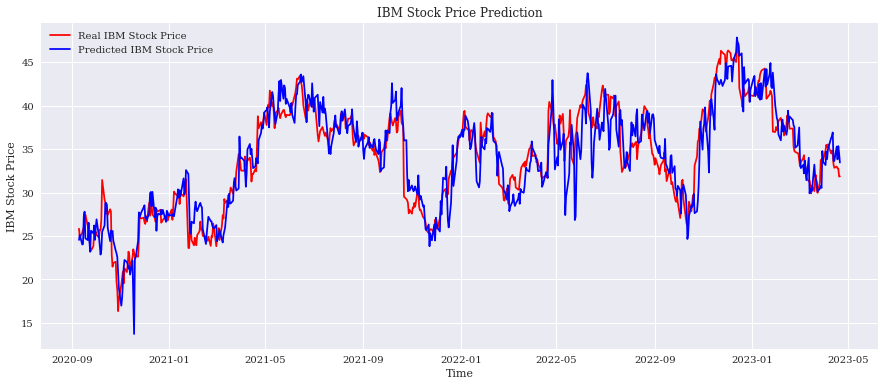

In [15]:
# Visualize the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

# Plot the real IBM stock price for the test data in red
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test[:,0], color = 'red', label = 'Real IBM Stock Price')

# Plot the predicted IBM stock price for the test data in blue
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred[:,0], color = 'blue', label = 'Predicted IBM Stock Price')

# Set the title, x-axis label, and y-axis label of the plot
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')

# Add a legend to the plot
plt.legend()

# Save the plot as an image
plt.savefig('ibm_pred_compare.png')

# Display the plot
plt.show()

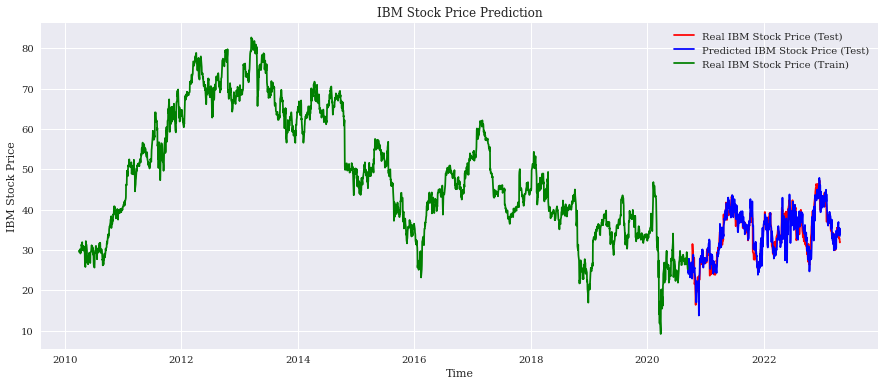

In [16]:
# Visualize the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

# Plot the real IBM stock price for the test data
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test[:,0], color = 'red', label = 'Real IBM Stock Price (Test)')

# Plot the predicted IBM stock price for the test data
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred[:,0], color = 'blue', label = 'Predicted IBM Stock Price (Test)')

# Plot the real IBM stock price for the train data
axes.plot(df_ibm[look_back:len(df_ibm)-len(y_test)].index, y_train[:,0], color = 'green', label = 'Real IBM Stock Price (Train)')

# Set the title and labels for the plot
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')

# Add a legend to the plot
plt.legend()

# Save the plot as an image
plt.savefig('ibm_pred_full.png')

# Display the plot
plt.show()

# Close the plot to free up memory
plt.close()

## 5. Predict date when the price rises by X amount

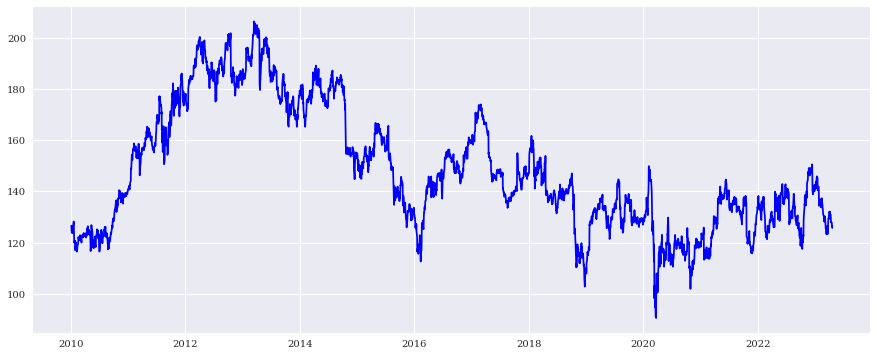

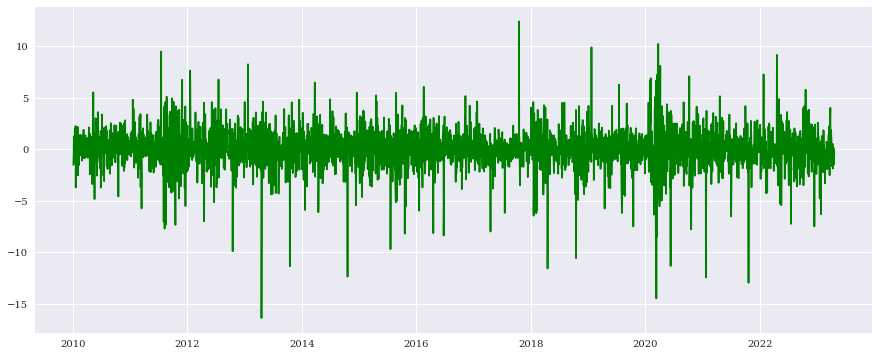

In [17]:
# Create two subplots for visualization
figure1, axes1 = plt.subplots(figsize=(15, 6))
figure2, axes2 = plt.subplots(figsize=(15, 6))

# Set the x-axis to display dates for both subplots
axes1.xaxis_date()
axes2.xaxis_date()

# Plot the original IBM stock price on the first subplot
axes1.plot(df_ibm_original, color='blue')

# Plot the difference of the IBM stock price on the second subplot
axes2.plot(df_ibm_original.diff(), color='green')

# Print an empty line to separate the code
print()